In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = 10, 10

In [4]:
df = pd.read_csv('raw_data.csv', index_col=0)
df.head()

,address,price,rooms,type,square,floor,max_floor,nearest,repair,living_square,...,washer,fridge,children,parking,phone,television,pool,billiards,sauna,url
0,г. Казань Гвардейская улица 48/2,800.0,1.0,студия,25.0,2.0,5.0,5000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://tatarstan.move.ru/objects/sdaetsya_1-k...
1,г. Кисловодск ул Тельмана 26,1200.0,1.0,квартиры на сутки,37.0,3.0,5.0,775.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://stavropol.move.ru/objects/sdaetsya_1-k...
2,"г. Санкт-Петербург, пр-кт. Российский, Дом 3 (...",1500.0,1.0,квартиры на сутки,43.0,3.0,12.0,529.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://spb.move.ru/objects/sdaetsya_1-komnatn...
3,Новосибирский р-н ст. Иня-Восточная Танковая у...,1600.0,1.0,квартиры на сутки,47.0,22.0,25.0,3000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://novosibirsk.move.ru/objects/sdaetsya_1...
4,NaN,1000.0,1.0,квартиры на сутки,34.0,6.0,9.0,65000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://samara.move.ru/objects/sdaetsya_1-komn...


In [5]:
df.index = np.arange(df.shape[0], dtype='int')

In [6]:
df.shape

(92128, 32)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68535 entries, 0 to 92102
Data columns (total 32 columns):
address              52331 non-null object
price                68535 non-null float64
rooms                66667 non-null float64
type                 68012 non-null object
square               68377 non-null float64
floor                65865 non-null float64
max_floor            65827 non-null float64
nearest              68401 non-null float64
repair               3707 non-null object
living_square        3668 non-null float64
square_kitchen       3694 non-null float64
type_of_rooms        3105 non-null object
type_of_balcony      3149 non-null object
type_of_bath         4012 non-null object
floor_covering       3595 non-null object
view_window          3606 non-null object
internet             4429 non-null object
security             814 non-null object
kitchen              2403 non-null object
free_layout          1381 non-null object
furniture            4437 non-null o

In [9]:
# добавим столбец с регионом, в котором расположена квартира
df['region'] = df['url'].map(lambda s: s[8: s.find('.')])
df['region'] = df['region'].replace('move','msk')
df['region'].value_counts().describe()

count      83.000000
mean      825.722892
std       910.214760
min         4.000000
25%       242.500000
50%       503.000000
75%      1114.000000
max      4598.000000
Name: region, dtype: float64

In [10]:
#удалим регионы, в которых меньше 100 объявлений
counts = df['region'].value_counts()
drop_regions = counts[counts < 100].index.values
df['region'] = df['region'].replace(drop_regions, 'drop_me')
df = df[df.region != 'drop_me']

In [11]:
# стобцы,в которых много пропусков
df.drop(['living_square', 'square_kitchen',
         'type_of_rooms', 'type_of_balcony', 'type_of_bath',
         'floor_covering', 'view_window'], axis=1, inplace=True)

In [12]:
df['is_repair'] = df['repair'].isnull().astype('int')
df.drop('repair', axis=1, inplace=True)

In [13]:
# кухня и телефон скорее всего есть везде, просто это не указывают
df.drop(['kitchen', 'phone'], axis=1, inplace=True)

In [14]:
# если какое-то "удобство" не описано, значит его нет
df.loc[:, 'internet': 'url'] = df.loc[:, 'internet': 'url'].fillna(0)
df.loc[:, 'internet': 'url'] = df.loc[:, 'internet': 'url'].replace('да', 1)

In [15]:
df.price.describe()

count    6.808900e+04
mean     2.576359e+03
std      7.019009e+04
min      1.000000e+00
25%      1.000000e+03
50%      1.500000e+03
75%      2.000000e+03
max      1.500200e+07
Name: price, dtype: float64

In [16]:
# 1 р/сут и 15 млн./сут хм...
df = df[(df.price >= 200) & (df.price <= 5000)]

In [17]:
df.square.describe()

count    64947.000000
mean        46.068117
std         27.625131
min          5.000000
25%         35.000000
50%         41.000000
75%         50.000000
max       2000.000000
Name: square, dtype: float64

In [18]:
df = df[df.square < 400]

In [19]:
df = df[df.floor <= df.max_floor]

In [20]:
# Указано ли расстояние до ближайшего метро / центра города
df['exist_nearest'] = df['nearest'].isnull().astype('int')

In [21]:
df.groupby('region')['rooms'].agg(lambda x: np.int(np.mean(x))).value_counts()

1.0    74
Name: rooms, dtype: int64

In [22]:
# в среднем в каждом регионе предлагают однокомнатные квартиры
df['rooms'] = df['rooms'].fillna(1)

In [23]:
# заполним пропуске средним значением по столбцу в этом регионе
df['square'] = df.groupby('region')['square'].apply(lambda x: x.fillna(x.mean()))

In [24]:
df['floor'] = df.groupby('region')['floor'].apply(lambda x: x.fillna(x.mean()))

In [25]:
df['max_floor'] = df.groupby('region')['max_floor'].apply(lambda x: x.fillna(x.mean()))

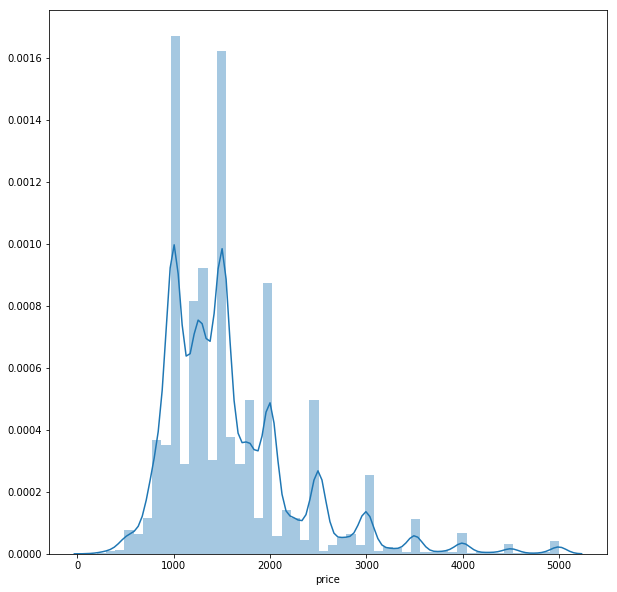

In [26]:
# Посмотрим на распределение целевой переменной в итоговом датасете
sb.distplot(df.price)
plt.show()

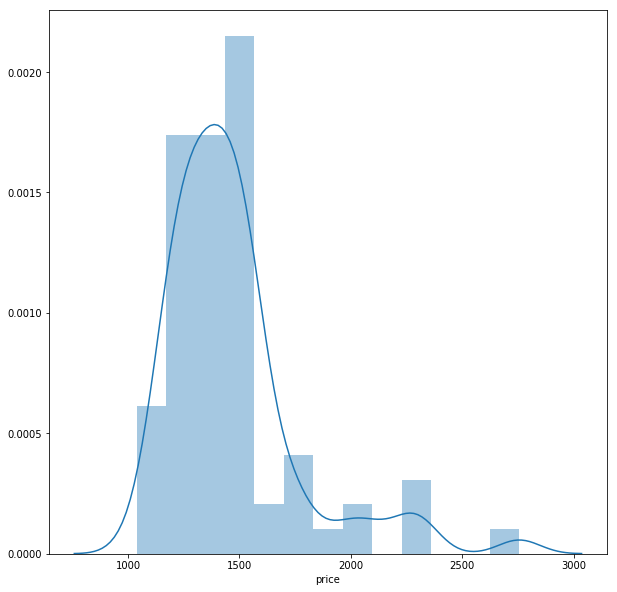

In [27]:
# И на среднюю цену по регионам
sb.distplot(df.groupby('region')['price'].mean())
plt.show()

In [28]:
mean = df.groupby('region')['price'].mean()
mean[mean > 2500]

region
msk    2755.274547
Name: price, dtype: float64

In [29]:
mean[(mean < 2500) & (mean > 1900)]

region
hmao           1937.101720
kamchatka      2317.734568
saha           2227.188940
salehard       2298.489474
spb            2024.044979
vladivostok    2093.284672
Name: price, dtype: float64

Средняя цена на аренду в Москве самая высокая. 

В Питере, Владивостоке, Салехарде, Сахе, Камчатке и Ханты-Мансийске выше, чем в основной массе регионов

In [30]:
df.shape

(63768, 25)

In [31]:
df.to_csv('data.csv')